In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [382]:
df = pd.read_csv("dataset.csv")
df.head()

,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop


In [383]:
ALL_GENRES = {}
for idx, row in df.iterrows():
    if row['genre'] not in ALL_GENRES:
        ALL_GENRES[row['genre']] = [idx]
    else:
        ALL_GENRES[row['genre']].append(idx)

ALL_GENRES

{'rock': [0,
  6,
  7,
  15,
  18,
  21,
  25,
  26,
  27,
  29,
  30,
  35,
  40,
  45,
  49,
  52,
  61,
  68,
  70,
  92,
  95,
  98,
  104,
  107,
  111,
  130,
  131,
  133,
  134,
  141],
 'classical': [1,
  5,
  8,
  11,
  13,
  16,
  32,
  33,
  34,
  44,
  50,
  51,
  69,
  72,
  73,
  78,
  94,
  100,
  102,
  105,
  109,
  116,
  117,
  119,
  122,
  124,
  125],
 'country': [2,
  9,
  12,
  14,
  20,
  31,
  37,
  43,
  46,
  48,
  54,
  55,
  59,
  60,
  63,
  67,
  77,
  80,
  82,
  90,
  99,
  114,
  118,
  121,
  123,
  128,
  129,
  139,
  140],
 'hip-hop': [3,
  4,
  19,
  22,
  23,
  28,
  42,
  53,
  56,
  57,
  62,
  64,
  66,
  74,
  75,
  79,
  81,
  84,
  91,
  93,
  101,
  112,
  115,
  126,
  127,
  132,
  135,
  137,
  138,
  142],
 'pop': [10,
  17,
  24,
  36,
  38,
  39,
  41,
  47,
  58,
  65,
  71,
  76,
  83,
  85,
  86,
  87,
  88,
  89,
  96,
  97,
  103,
  106,
  108,
  110,
  113,
  120,
  136,
  143,
  144,
  145,
  146]}

## Generating word embeddings for the keywords using BoW

In [384]:
def create_embeddings(keyword):

    ans = np.zeros(26)
    for i in keyword:
        ans[ord(i.upper()) - ord('A')] = 1

    return ans

create_embeddings('slow')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0.])

In [385]:
def give_df_keyword_embeddings(df):
    arr = []
    for idx, row in df.iterrows():
        t = []
        t.append(create_embeddings(row['keyword_1']))
        t.append(create_embeddings(row['keyword_2']))
        t.append(create_embeddings(row['keyword_3']))
        arr.append(t)

    return np.array(arr)

In [386]:
embeddings = give_df_keyword_embeddings(df)
embeddings

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

## Dimensionality Reduction for each keyword matrix

In [387]:
class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        cov = np.cov(X.T)
        
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        eigenvectors = eigenvectors.T

        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components.T)

In [388]:
def transform_embeddings(embeddings, PCA):

    arr = []
    for i, row in enumerate(embeddings):
        pca = PCA(2)
        pca.fit(row)
        reduced_dim_row = pca.transform(row)
        arr.append(reduced_dim_row)
    
    return np.array(arr)

transformed_embeddings = transform_embeddings(embeddings, PCA)

## Combining the embeddings into one

In [389]:
def combine_embeddings(transformed_embeddings):
    arr = []

    for i, row in enumerate(transformed_embeddings):
        t = [0, 0]
        for j, vals in enumerate(row):
            t[0] += vals[0]
            t[1] += vals[1]
        t[0] /= len(row)
        t[0] = t[0].real
        t[1] /= len(row)
        t[1] = t[1].real
        
        arr.append(t)

    return np.array(arr)

combined_embeddings = combine_embeddings(transformed_embeddings)

## Apply K-Means clustering

In [390]:
def get_squared_dis(x1, y1, x2, y2):
    return (x1 - x2)**2 + (y1 - y2)**2

In [391]:
def compute_init_centroids(K, matrix):
    random_idx = np.random.permutation(matrix.shape[0])
    
    centroids = matrix[random_idx[:K]]
    
    return centroids
    

In [392]:
def get_cluster_index(centroids, matrix, K):
    m ,n = matrix.shape
    cluster_index = np.zeros(m)

    for i in range(m):

        d = get_squared_dis(matrix[i][0], matrix[i][1], centroids[0][0], centroids[0][1])
        ans = 0
        for j in range(1, K):
            new_d = get_squared_dis(matrix[i][0], matrix[i][1], centroids[j][0], centroids[j][1])
            if(new_d < d):
                d = new_d
                ans = j

        cluster_index[i] = ans

    return cluster_index
                
            

In [393]:
def compute_centroids(cluster_index, matrix, centroids, k):
    m, n = matrix.shape
    new_centroids = []

    for i in range(k):

        x_m, y_m = 0, 0
        n = 0
        for j in range(m):
            if cluster_index[j] == i:
                x_m += matrix[j][0]
                y_m += matrix[j][1]
                n += 1

        if n != 0:
            x_m /= n
            y_m /= n

        new_centroids.append([x_m ,y_m])

    return np.array(new_centroids)

In [394]:
def run_KMeans(matrix, K, iterations):
    m, n = matrix.shape
    centroids = compute_init_centroids(K, matrix)

    for i in range(iterations):

        cluster_index = get_cluster_index(centroids, matrix, K)

        centroids = compute_centroids(cluster_index, matrix, centroids, K)

    return cluster_index, centroids

In [395]:
def cal_shilloute_dis(cluster_index, centroids, matrix, K):
    m, n = matrix.shape

    si_scores = np.zeros(K)

    for i in range(m):

        point = matrix[i]

        # calculating cohesion <intra cluster distance>
        arr = []
        for j in range(m):
            if cluster_index[j] == cluster_index[i] and i != j:
                arr.append(matrix[j])

        if len(arr) > 1:
            a_i = np.mean([get_squared_dis(point[0], point[1], other[0], other[1]) for other in arr if not np.array_equal(point, other)])
        else:
            a_i = 0


        # calculating separation <mean distance from nearest cluster>
        b_i = np.inf

        for j in range(K):
            if j == cluster_index[i]:
                continue

            arr = []
            for k in range(m):
                if cluster_index[k] == j:
                    arr.append(matrix[k])

            b_i = min(b_i, np.mean([get_squared_dis(point[0], point[1], other[0], other[1]) for other in arr]))

        # computer score
        if max(a_i, b_i) > 0 :
            si_scores =  (b_i - a_i) / max(a_i, b_i)


    return np.mean(si_scores)
        

In [396]:
def apply_clustering(matrix):
    best, K = -1, 1
    best_cluster_index, best_centroids = None, None
    
    for i in range(2, 10):
        cluster_index, centroids = run_KMeans(matrix, i, 20)
        score = cal_shilloute_dis(cluster_index, centroids, matrix, i)
        
        if score > best:
            best = score
            K = i
            best_cluster_index = cluster_index
            best_centroids = centroids
    
    return best, K, best_cluster_index, best_centroids

In [397]:
best, K, cluster_index, centroids = apply_clustering(combined_embeddings)
best, K, cluster_index, centroids

(np.float64(0.7960753532182103),
 8,
 array([7., 6., 6., 7., 3., 6., 0., 6., 2., 0., 4., 5., 6., 0., 6., 2., 2.,
        4., 6., 5., 3., 6., 5., 6., 6., 6., 0., 0., 7., 6., 6., 2., 2., 2.,
        6., 2., 6., 3., 2., 2., 6., 6., 3., 2., 5., 2., 6., 3., 6., 6., 2.,
        5., 6., 7., 6., 5., 2., 2., 7., 0., 7., 6., 6., 0., 0., 4., 6., 2.,
        0., 6., 6., 4., 6., 5., 0., 7., 2., 6., 7., 3., 0., 5., 0., 6., 2.,
        0., 0., 0., 6., 3., 5., 2., 6., 1., 7., 6., 4., 1., 6., 6., 6., 2.,
        6., 7., 0., 6., 2., 5., 2., 0., 3., 7., 5., 5., 6., 0., 3., 2., 3.,
        6., 5., 6., 0., 2., 5., 2., 4., 6., 2., 0., 7., 6., 5., 6., 0., 4.,
        6., 6., 2., 0., 6., 2., 6., 0., 6., 3., 2.]),
 array([[ 1.30330529e-16,  1.52856793e-16],
        [ 5.13581319e-34,  2.96059473e-16],
        [ 7.66582565e-17,  7.83103741e-17],
        [ 8.57899610e-17,  1.68215610e-17],
        [-6.45645086e-33,  1.42742960e-16],
        [ 2.83723662e-17,  2.34380416e-17],
        [-1.68093069e-33, -1.25381970

## Graph for clustering

In [398]:
COLOR_MAP = {}
for i in range(K):
    COLOR_MAP[i] = (random.random(), random.random(), random.random())
def get_color_for_plot(i, K):
    return COLOR_MAP[i]

In [399]:
def make_graph(K, cluster_index, centroids, matrix):

    m, n = matrix.shape

    # plotting data points
    for i in range(m):
        color = get_color_for_plot(cluster_index[i], K)
        plt.scatter(matrix[i][0], matrix[i][1], marker = "o", color = color, s=50, edgecolors="black")

    # plotting centroids
    for i in range(K):
        color = get_color_for_plot(i, K)
        plt.scatter(centroids[i][0], centroids[i][1], marker = "x", color = "black")

    plt.title("Scatter Plot Based on the algorithms applied")

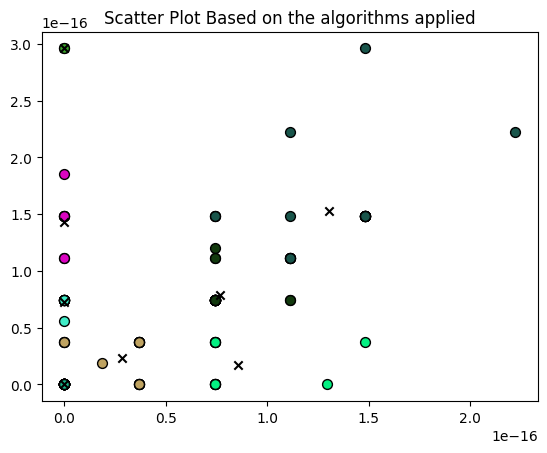

In [400]:
make_graph(K, cluster_index, centroids, combined_embeddings)

In [401]:
def give_intersection(l1, l2):
    ans = 0
    for i in l1:
        if i in l2:
            ans += 1

    return ans

In [402]:
def get_genre_by_cluster(cluster_index, all_genres, matrix, K):
    mapping = []

    for i in range(K):
        ans = "Not Known"
        n = 0
        
        l = []
        for j in range(len(cluster_index)):
            if cluster_index[j] == i:
                l.append(j)

        for key in ALL_GENRES:
            intersection = give_intersection(ALL_GENRES[key], l)
            if intersection > n:
                n = intersection
                ans = key

        mapping.append(ans)

    return mapping

GENRE_BY_CLUSTER = get_genre_by_cluster(cluster_index, ALL_GENRES, combined_embeddings, K)
GENRE_BY_CLUSTER

['country',
 'hip-hop',
 'classical',
 'pop',
 'pop',
 'classical',
 'rock',
 'hip-hop']

In [403]:
def predict(keyword_1, keyword_2, keyword_3, centroids):
    arr = []
    arr.append(create_embeddings(keyword_1))
    arr.append(create_embeddings(keyword_2))
    arr.append(create_embeddings(keyword_3))
    
    pca = PCA(2)
    pca.fit(arr)
    arr = pca.transform(arr)

    combined_arr = [0, 0]
    for i in arr:
        combined_arr[0] += i[0]
        combined_arr[1] += i[1]
    combined_arr[0] /= len(arr)
    combined_arr[0] = combined_arr[0].real
    combined_arr[1] /= len(arr)
    combined_arr[1] = combined_arr[1].real

    d_min = np.inf
    centroid_idx = -1
    for i in range(len(centroids)):
        d = get_squared_dis(centroids[i][0], centroids[i][1], combined_arr[0], combined_arr[1])
        if d < d_min:
            d_min = d
            centroid_idx = i

    return GENRE_BY_CLUSTER[centroid_idx]

In [404]:
predict("piano", "calm", "slow", centroids)

'classical'

In [405]:
predict("guitar", "emotional", "distorted", centroids)

'classical'

In [406]:
predict("synth", "mellow", "distorted", centroids)

'country'

In [407]:
predict("banjo", "happy", "acoustic", centroids)

'rock'